# Correlation for a single GRB

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import popsynth
from popsynth.aux_samplers.trunc_normal_aux_sampler import TruncatedNormalAuxSampler
from popsynth.aux_samplers.lognormal_aux_sampler import LogNormalAuxSampler
from aux_samplers import TDecaySampler, DurationSampler, LumSampler, EpeakObsSampler

import cosmogrb

## Simulate one GRB in popsynth

In [93]:
pop_gen = popsynth.populations.SFRPopulation(r0=1./20, rise=1., decay=4.0,
                                             peak=1.5, r_max=7.0)

t90 = LogNormalAuxSampler(name="log_t90", observed=False)
t90.mu=10
t90.tau=0.25

log_ep = LogNormalAuxSampler(name="log_ep", observed=False)
log_ep.mu=300
log_ep.tau=0.4

alpha = TruncatedNormalAuxSampler(name="alpha", observed=False)
alpha.lower=-1.5
alpha.upper=0.0
alpha.mu=-1
alpha.tau=0.25

ep_tau = TruncatedNormalAuxSampler(name="ep_tau", observed=False)
ep_tau.lower=-2
ep_tau.upper=-1
ep_tau.mu=-1.5
ep_tau.tau=0.25

log_nrest = LogNormalAuxSampler(name="log_nrest", observed=False)
log_nrest.mu = 1e52
log_nrest.tau = 0.1

gamma = TruncatedNormalAuxSampler(name="gamma", observed=False)
gamma.mu = 1.5
gamma.tau = 0.5
gamma.lower = 1.0
gamma.upper = 2.0

duration = DurationSampler()
obs_lum = LumSampler()
log_ep_obs = EpeakObsSampler()

duration.set_secondary_sampler(t90)
obs_lum.set_secondary_sampler(log_ep)
obs_lum.set_secondary_sampler(log_nrest)
obs_lum.set_secondary_sampler(gamma)
log_ep_obs.set_secondary_sampler(log_ep)

pop_gen.add_observed_quantity(duration)
pop_gen.add_observed_quantity(obs_lum)
pop_gen.add_observed_quantity(log_ep_obs)
pop_gen.add_observed_quantity(alpha)
pop_gen.add_observed_quantity(ep_tau)

registering auxilary sampler: duration
registering derived luminosity sampler: obs_lum
registering auxilary sampler: log_ep_obs
registering auxilary sampler: alpha
registering auxilary sampler: ep_tau


In [94]:
population = pop_gen.draw_survey(no_selection=True, boundary=1e-2, 
                                 verbose=False, flux_sigma=0.0)
population.writeto('data/single_grb.h5')

No Selection! Added back all objects


## Define GRB

In [95]:
from corr_cpl.corr_cpl_source import CorrCPLSourceFunction
from corr_cpl.corr_cpl_grb import GBMGRB_CORR_CPL

In [96]:
grb = GBMGRB_CORR_CPL(
    ra=np.rad2deg(population.phi[0]),
    dec=90 - np.rad2deg(population.theta[0]),
    z=population.distances[0],
    peak_flux=population.latent_fluxes[0],
    alpha=population.alpha[0],
    ep=np.power(10, population.log_ep_obs[0]),
    ep_tau=population.ep_tau[0],
    Nrest=np.power(10, population.log_nrest[0]),
    gamma=population.gamma[0],
    duration=population.duration[0],
    T0=0.,
)

grb.info()

,0
name,SynthGRB
z,2.58177
ra,234.496
dec,-60.0292
duration,16.7751
T0,0


,0
peak_flux,4.629658e-06
alpha,-1.032055e+00
ep_tau,-1.299780e+00
Nrest,8.975724e+51
gamma,1.340622e+00


,0


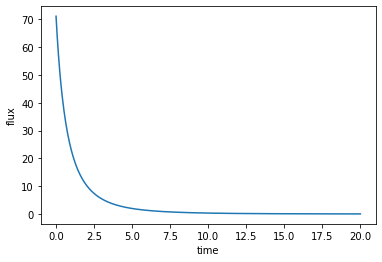

In [97]:
time = np.linspace(0, 20, 500)

grb.display_energy_integrated_light_curve(time);

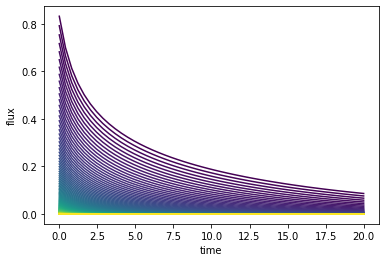

In [98]:
time = np.linspace(0, 20)
energy = np.logspace(1, 3, 100)

grb.display_energy_dependent_light_curve(time, energy, cmap='viridis')

Text(0, 0.5, 'flux')

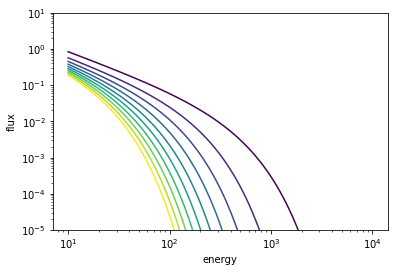

In [99]:
time = np.linspace(0, 10, 10)
energy = np.logspace(1, 4, 100)
out = list(grb._lightcurves.values())[0]._source._source_function.evolution(energy, 
                                                                            time)
fig, ax = plt.subplots()
for y, c in zip(out, plt.cm.viridis(np.linspace(0,1,len(out)))):
    ax.plot(energy, y, color=c)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1e-5, 1e1)
ax.set_xlabel('energy')
ax.set_ylabel('flux')

## Simulate GRB

In [100]:
#grb.go(serial=True)
#grb.save('data/test_grb.h5')

In [101]:
grb_reload = cosmogrb.GRBSave.from_file('data/test_grb.h5')

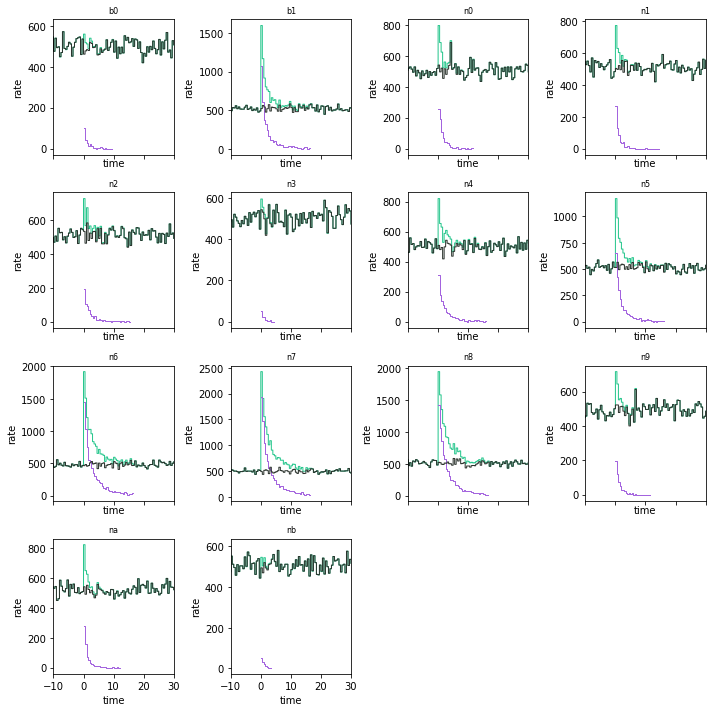

In [102]:
fig, axes = plt.subplots(4,4,sharex=True,sharey=False,figsize=(10,10))
row=0
col = 0
for k,v  in grb_reload.items():
    ax = axes[row][col]

    lightcurve =v['lightcurve']

    lightcurve.display_lightcurve(dt=.5, ax=ax,lw=1,color='#25C68C')
    lightcurve.display_source(dt=.5,ax=ax,lw=1,color="#A363DE")
    lightcurve.display_background(dt=.5,ax=ax,lw=1, color="#2C342E")
    ax.set_xlim(-10, 30)
    ax.set_title(k,size=8)



    if col < 3:
        col+=1
    else:
        row+=1
        col=0

axes[3,2].set_visible(False)
axes[3,3].set_visible(False)
plt.tight_layout()

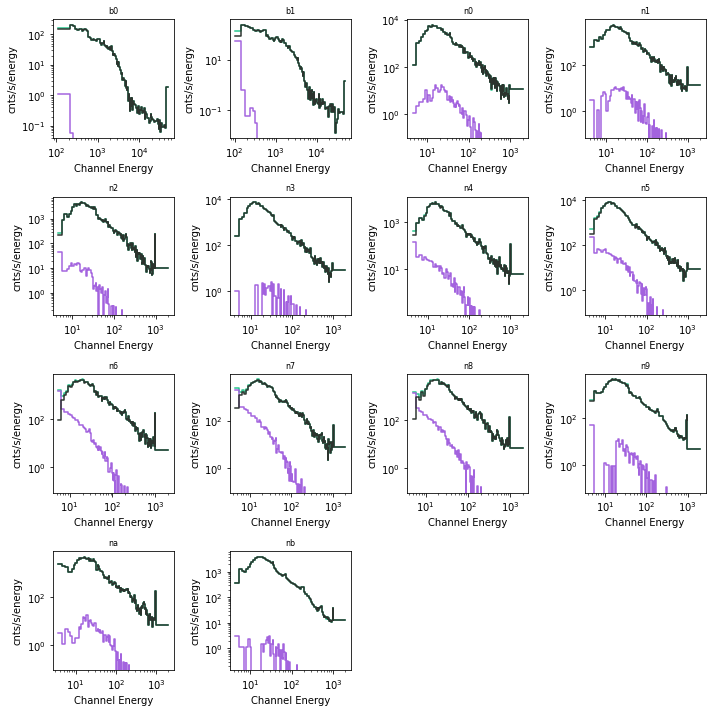

In [103]:
fig, axes = plt.subplots(4,4,sharex=False,sharey=False,figsize=(10,10))
row=0
col = 0

for k, v in grb_reload.items():
    ax = axes[row][col]

    lightcurve = v['lightcurve']

    lightcurve.display_count_spectrum(tmin=0, tmax=5, ax=ax,color='#25C68C')
    lightcurve.display_count_spectrum_source(tmin=0, tmax=5, ax=ax,color="#A363DE")
    lightcurve.display_count_spectrum_background(tmin=0, tmax=5, ax=ax, color="#2C342E")
    ax.set_title(k,size=8)

    if col < 3:
        col+=1
    else:
        row+=1
        col=0

axes[3,2].set_visible(False)
axes[3,3].set_visible(False)
plt.tight_layout()

## Simulate universe

In [84]:
from corr_cpl.corr_cpl_universe import GBM_CORR_CPL_Universe

In [104]:
#universe = GBM_CORR_CPL_Universe('data/single_grb.h5', save_path="data")

#universe.go(client=None)

#universe.save('data/survey.h5')

## View survey

In [105]:
from cosmogrb.universe.survey import Survey

In [106]:
survey = Survey.from_file('data/survey.h5')
survey.info()

,0
n_grbs,1
is_processed,False


In [107]:
survey['SynthGRB_0'].grb

name          SynthGRB_0
z                2.58177
ra               234.496
dec             -60.0292
duration         16.7751
T0                     0
Nrest        8.97572e+51
alpha           -1.03206
ep_start         282.023
ep_tau          -1.29978
gamma            1.34062
peak_flux    4.62966e-06

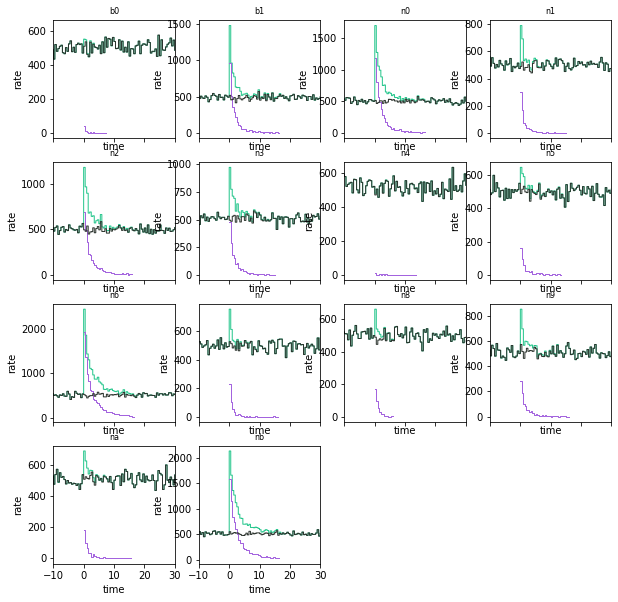

In [108]:
fig, axes = plt.subplots(4,4,sharex=True,sharey=False,figsize=(10,10))
row=0
col = 0
for k,v  in survey['SynthGRB_0'].grb.items():
    ax = axes[row][col]

    lightcurve =v['lightcurve']

    lightcurve.display_lightcurve(dt=.5, ax=ax,lw=1,color='#25C68C')
    lightcurve.display_source(dt=.5,ax=ax,lw=1,color="#A363DE")
    lightcurve.display_background(dt=.5,ax=ax,lw=1, color="#2C342E")
    ax.set_xlim(-10, 30)
    ax.set_title(k,size=8)



    if col < 3:
        col+=1
    else:
        row+=1
        col=0

axes[3,2].set_visible(False)
axes[3,3].set_visible(False)

## Logging

In [13]:
import logging
logger = logging.getLogger("cosmogrb")
logger.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
logger.addHandler(ch)